Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
loading Roboflow workspace...
loading Roboflow project...
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Checking for mask at: /content/processed_masks/frame_00022_png.rf.8905483a92281d8be51e71fb2863529b_mask_mask.png
Checking for mask at: /content/processed_masks/frame_00030_png.rf.e08d779520bdb8ab85f148681cdd5650_mask_mask.png
Checking for mask at: /content/processed_masks/frame_00007_png.rf.942671855650203bc231c5d2a00be296_mask_mask.png
Checking for mask at: /content/processed_masks/frame_00013_png.rf.076a86ba5f9ac5c9fdb21673d902c850_mask_mask.png
Checking for mask at: /content/processed_masks/frame_00042_png.rf.d1144c583ab57e207773fb1d9aedf499_mask_mask.png
Checking for mask at: /content/processed_masks/frame_00025_png.rf.22a26e5b78de5533beb7234cd1a63561_mask_mask.png
Checking for mask at: /content/processed_masks/frame

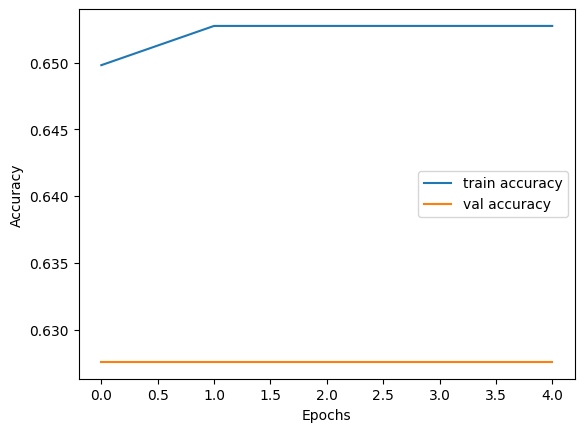

In [3]:
# Step 1: Install necessary libraries
!pip install tensorflow opencv-python pycocotools roboflow

# Step 2: Mount Google Drive (if needed to save images and models)
from google.colab import drive
drive.mount('/content/drive')

# Step 3: Import required libraries
import json
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from roboflow import Roboflow



rf = Roboflow(api_key="kraOrcnbAS9WG9opqyxw")
project = rf.workspace("imagesegmentation-5fcdp").project("roads-1bztp")
version = project.version(5)
dataset = version.download("coco-segmentation")




# Step 5: Set paths to your downloaded dataset
annotations_path = "/content/roads-5/train/_annotations.coco.json"  # Adjust this path if needed
images_path = "/content/roads-5/train"  # Path to images

# Step 6: Load COCO annotations and prepare image-mask pairs
coco = COCO(annotations_path)

# Get all image IDs
image_ids = coco.getImgIds()

# Prepare output directories for images and masks
output_images = "/content/processed_images/"
output_masks = "/content/processed_masks/"
os.makedirs(output_images, exist_ok=True)
os.makedirs(output_masks, exist_ok=True)

# Step 7: Process each image and create binary segmentation masks
for image_id in image_ids:
    # Get image info
    image_info = coco.loadImgs(image_id)[0]
    image_filename = image_info['file_name']
    image_path = os.path.join(images_path, image_filename)

    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Get the annotations for this image
    annotation_ids = coco.getAnnIds(imgIds=image_id)
    annotations = coco.loadAnns(annotation_ids)

    # Create an empty mask (same size as the image)
    mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

    # Loop through the annotations (segmentation polygons)
    for ann in annotations:
        if 'segmentation' in ann:
            # Draw polygons on the mask image (1 for road, 0 for background)
            segmentation = ann['segmentation']
            if isinstance(segmentation, list):  # If the segmentation is a polygon (list of points)
                for polygon in segmentation:
                    # Create a polygon and fill it with 1s (road)
                    poly = np.array(polygon, dtype=np.int32).reshape((-1, 1, 2))
                    cv2.fillPoly(mask, [poly], 1)  # Fill the polygon with '1' (road)

    # Save the image and mask
    cv2.imwrite(os.path.join(output_images, image_filename), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    mask_filename = image_filename.replace(".jpg", "_mask.png").replace(".png", "_mask.png")
    cv2.imwrite(os.path.join(output_masks, mask_filename), mask)

# Step 8: Load processed images and masks into arrays
def load_images_and_masks(image_dir, mask_dir, img_size=(256, 256)):
    images = []
    masks = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg"):  # Process only .jpg images
            # Load image
            img = load_img(os.path.join(image_dir, filename), target_size=img_size)
            img = img_to_array(img) / 255.0  # Normalize to [0, 1]
            images.append(img)

            # Get the corresponding mask filename (handle extra '_mask' in mask names)
            mask_filename = filename.replace(".jpg", "_mask_mask.png")  # Adjust to match the mask filename pattern
            mask_path = os.path.join(mask_dir, mask_filename)

            # Debugging print statement to check mask path
            print(f"Checking for mask at: {mask_path}")

            # Check if the mask exists
            if os.path.exists(mask_path):
                mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")
                mask = img_to_array(mask) / 255.0  # Normalize to [0, 1] (1 for road, 0 for background)
                masks.append(mask)
            else:
                print(f"Mask for {filename} not found!")  # Debugging message for missing masks

    # Print the number of loaded images and masks
    print(f"Loaded {len(images)} images and {len(masks)} masks.")

    return np.array(images), np.array(masks)

# Set paths to your processed images and masks
image_dir = "/content/processed_images/"
mask_dir = "/content/processed_masks/"

# Load images and masks
images, masks = load_images_and_masks(image_dir, mask_dir)

# Step 9: Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)




# Step 10: Define the U-Net model architecture for binary segmentation
def unet(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Contracting Path
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expansive Path
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output layer: 1 channel for binary segmentation (road vs background)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)  # Binary segmentation

    model = models.Model(inputs, outputs)
    return model

# Step 11: Build the U-Net model
model = unet(input_size=(256, 256, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 12: Train the U-Net model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=5)

# Step 13: Save the trained model (optional)
model.save('/content/drive/MyDrive/road_segmentation_unet_model.h5')

# Step 14: Visualize Training History (optional)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
